In [1]:
import time
t_start = time.time()

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # suppress tensorflow information messages

import sys
import numpy as np
from scipy import stats
import scipy as sp
import multiprocessing
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

HOME_PATH = os.path.abspath("/root/work/QE-mls") # path to QE_mls
sys.path.append(HOME_PATH + "/qe")
print("Home path:", HOME_PATH)

# custom modules
import paper_plot as pp
# Import the W boson regressor module
import nn
nn.BATCH_SIZE = 512

Home path: /root/work/QE-mls


In [2]:
# ROOT need to be imported after tensorflow
import ROOT
from ROOT import TLorentzVector, TVector3

# some global variables
dir_name = HOME_PATH + "/14th_trial/reg_main/ww_resregressor_result/"
plot = pp.Plotter()
WORKERS = 16

In [3]:
import h5py


def load_particles_from_h5(filename="mc20_truth.h5"):
    """
    Load particle data from an HDF5 file

    Args:
        filename: Path to the HDF5 file

    Returns:
        Dictionary with the loaded data
    """
    result = {}

    with h5py.File(filename, "r") as f:
        # For each group in the file
        for group_name in f.keys():
            group_data = {}

            # Load datasets (numpy arrays)
            for dataset_name in f[group_name].keys():
                group_data[dataset_name] = f[group_name][dataset_name][:]

            # Load attributes (scalars)
            for attr_name, attr_value in f[group_name].attrs.items():
                group_data[attr_name] = attr_value

            result[group_name] = group_data

    return result

In [4]:
mc20_data = load_particles_from_h5("/root/data/mc20_truth.h5")
mc20_data.keys()

dict_keys(['higgs', 'lead_w', 'sublead_w', 'truth_dilep', 'truth_dilep_car', 'truth_lead_lep', 'truth_lead_lep_car', 'truth_lead_nu', 'truth_lead_nu_car', 'truth_sublead_lep', 'truth_sublead_lep_car', 'truth_sublead_nu', 'truth_sublead_nu_car'])

In [5]:
# SM truth
truth_lead_lep = mc20_data["truth_lead_lep"]
truth_sublead_lep = mc20_data["truth_sublead_lep"]
truth_lead_nu = mc20_data["truth_lead_nu"]
truth_sublead_nu = mc20_data["truth_sublead_nu"]
truth_lead_lep_p4 = mc20_data["truth_lead_lep"]["p4"]
truth_sublead_lep_p4 = mc20_data["truth_sublead_lep"]["p4"]
truth_lead_nu_p4 = mc20_data["truth_lead_nu"]["p4"]
truth_sublead_nu_p4 = mc20_data["truth_sublead_nu"]["p4"]
truth_met_pt = np.sqrt(np.square((truth_lead_nu_p4 + truth_sublead_nu_p4)[...,0:2]).sum(axis=-1))

# CAR truth
truth_lead_lep_car = mc20_data["truth_lead_lep_car"]
truth_sublead_lep_car = mc20_data["truth_sublead_lep_car"]
truth_lead_nu_car = mc20_data["truth_lead_nu_car"]
truth_sublead_nu_car = mc20_data["truth_sublead_nu_car"]
truth_lead_lep_car_p4 = mc20_data["truth_lead_lep_car"]["p4"]
truth_sublead_lep_car_p4 = mc20_data["truth_sublead_lep_car"]["p4"]
truth_lead_nu_car_p4 = mc20_data["truth_lead_nu_car"]["p4"]
truth_sublead_nu_car_p4 = mc20_data["truth_sublead_nu_car"]["p4"]
truth_met_pt_car = np.sqrt(np.square((truth_lead_nu_car_p4 + truth_sublead_nu_car_p4)[...,0:2]).sum(axis=-1))

# W bosons (SM and CAR use the same W bosons data)
w_lead_p4 = mc20_data["lead_w"]["p4"]
w_sublead_p4 = mc20_data["sublead_w"]["p4"]

In [6]:
print("Truth: pre-cut")
cut_pre_pt_lead = truth_lead_lep["pt"] > 22
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep["pt"] > 15
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep["energy"] + truth_sublead_lep["energy"])
    - np.square(truth_lead_lep["px"] + truth_sublead_lep["px"])
    - np.square(truth_lead_lep["py"] + truth_sublead_lep["py"])
    - np.square(truth_lead_lep["pz"] + truth_sublead_lep["pz"])
    > 10**2
)
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt > 20
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print("Total", len(truth_lead_lep["energy"]) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# CAR
print("")
print("CAR: pre-cut")
cut_pre_pt_lead = truth_lead_lep_car["pt"] > 22
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep_car["pt"] > 15
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep_car["energy"] + truth_sublead_lep_car["energy"])
    - np.square(truth_lead_lep_car["px"] + truth_sublead_lep_car["px"])
    - np.square(truth_lead_lep_car["py"] + truth_sublead_lep_car["py"])
    - np.square(truth_lead_lep_car["pz"] + truth_sublead_lep_car["pz"])
    > 10**2
)
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt_car > 20
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT_CAR = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print("Total", len(truth_lead_lep_car["energy"]) - np.sum(PRE_CUT_CAR * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

Truth: pre-cut
260653
1174171
148392
287355
Total 1502903

CAR: pre-cut
336735
1292162
65248
441435
Total 1634918


In [7]:
# force to use the same cuts for both truth and CAR

PRE_CUT_INST = PRE_CUT_CAR & PRE_CUT
print("Total", np.sum(PRE_CUT_INST * 1))

Total 700374


In [8]:
# training objects
lead_lep_px = np.concatenate([truth_lead_lep["px"][PRE_CUT_INST], truth_lead_lep_car["px"][PRE_CUT_INST]])
lead_lep_py = np.concatenate([truth_lead_lep["py"][PRE_CUT_INST], truth_lead_lep_car["py"][PRE_CUT_INST]])
lead_lep_pz = np.concatenate([truth_lead_lep["pz"][PRE_CUT_INST], truth_lead_lep_car["pz"][PRE_CUT_INST]])
lead_lep_energy = np.concatenate([truth_lead_lep["energy"][PRE_CUT_INST], truth_lead_lep_car["energy"][PRE_CUT_INST]])
sublead_lep_px = np.concatenate([truth_sublead_lep["px"][PRE_CUT_INST], truth_sublead_lep_car["px"][PRE_CUT_INST]])
sublead_lep_py = np.concatenate([truth_sublead_lep["py"][PRE_CUT_INST], truth_sublead_lep_car["py"][PRE_CUT_INST]])
sublead_lep_pz = np.concatenate([truth_sublead_lep["pz"][PRE_CUT_INST], truth_sublead_lep_car["pz"][PRE_CUT_INST]])
sublead_lep_energy = np.concatenate([truth_sublead_lep["energy"][PRE_CUT_INST], truth_sublead_lep_car["energy"][PRE_CUT_INST]])
lead_nu_px = np.concatenate([truth_lead_nu["px"][PRE_CUT_INST], truth_lead_nu_car["px"][PRE_CUT_INST]])
lead_nu_py = np.concatenate([truth_lead_nu["py"][PRE_CUT_INST], truth_lead_nu_car["py"][PRE_CUT_INST]])
sublead_nu_px = np.concatenate([truth_sublead_nu["px"][PRE_CUT_INST], truth_sublead_nu_car["px"][PRE_CUT_INST]])
sublead_nu_py = np.concatenate([truth_sublead_nu["py"][PRE_CUT_INST], truth_sublead_nu_car["py"][PRE_CUT_INST]])
met_px = lead_nu_px + sublead_nu_px
met_py = lead_nu_py + sublead_nu_py

np.random.seed(nn.SEED)
shuffle_ind = np.random.permutation(len(lead_lep_px))

train = np.column_stack(
    (
        lead_lep_px,
        lead_lep_py,
        lead_lep_pz,
        lead_lep_energy,
        sublead_lep_px,
        sublead_lep_py,
        sublead_lep_pz,
        sublead_lep_energy,
        met_px,
        met_py,
    )
)

train = train[shuffle_ind]
print("Training objects shape:", train.shape)

Training objects shape: (1400748, 10)


In [9]:
# target objects

w_lead = mc20_data["lead_w"]
w_sublead = mc20_data["sublead_w"]
target = np.column_stack(
    (
        np.concatenate([w_lead["px"][PRE_CUT_INST], w_lead["px"][PRE_CUT_INST]]),
        np.concatenate([w_lead["py"][PRE_CUT_INST], w_lead["py"][PRE_CUT_INST]]),
        np.concatenate([w_lead["pz"][PRE_CUT_INST], w_lead["pz"][PRE_CUT_INST]]),
        np.concatenate([w_lead["energy"][PRE_CUT_INST], w_lead["energy"][PRE_CUT_INST]]),
        np.concatenate([w_sublead["px"][PRE_CUT_INST], w_sublead["px"][PRE_CUT_INST]]),
        np.concatenate([w_sublead["py"][PRE_CUT_INST], w_sublead["py"][PRE_CUT_INST]]),
        np.concatenate([w_sublead["pz"][PRE_CUT_INST], w_sublead["pz"][PRE_CUT_INST]]),
        np.concatenate([w_sublead["energy"][PRE_CUT_INST], w_sublead["energy"][PRE_CUT_INST]]),
        np.concatenate([w_lead["m"][PRE_CUT_INST], w_lead["m"][PRE_CUT_INST]]),
        np.concatenate([w_sublead["m"][PRE_CUT_INST], w_sublead["m"][PRE_CUT_INST]]),
    )
)

target = target[shuffle_ind]
print("Target objects shape:", target.shape)

Target objects shape: (1400748, 10)


In [10]:
# Train-test split
if len(train) == len(target):
	indices = np.arange(len(train))
else:
	sys.exit("Error: train and targe shapes do not match!")

train_idx, temp_idx = train_test_split(
	indices, train_size=0.8, random_state=nn.SEED
)
valid_idx, test_idx = train_test_split(
	temp_idx, train_size=0.5, random_state=nn.SEED
)

train_x, valid_x, test_x = train[train_idx], train[valid_idx], train[test_idx]
train_y, valid_y, test_y = target[train_idx], target[valid_idx], target[test_idx]

print("Train shape:", train_x.shape, "Valid shape:", valid_x.shape, "Test shape:", test_x.shape)

Train shape: (1120598, 10) Valid shape: (140075, 10) Test shape: (140075, 10)


In [ ]:
# W&B initialization
wandb.init(
    project='PcRes regressor mixing training', 
    name='mae batch_size: %d' % nn.BATCH_SIZE)
config = wandb.config
config.batch_size = nn.BATCH_SIZE

# Create datasets
train_dataset = (
	tf.data.Dataset.from_tensor_slices((train_x, train_y))
	.cache()
	.batch(nn.BATCH_SIZE)
	.prefetch(tf.data.AUTOTUNE)
)
valid_dataset = (
	tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
	.cache()
	.batch(nn.BATCH_SIZE)
	.prefetch(tf.data.AUTOTUNE)
)

# Build and train model
base_model = nn.build_model(input_shape=train_x.shape[-1])
model = nn.CustomModel(base_model)
model.summary()
model.compile(
	optimizer=tf.keras.optimizers.Adam(learning_rate=nn.LEARNING_RATE),
	loss_weights=nn.LOSS_WEIGHTS,
)

callbacks = [
	tf.keras.callbacks.EarlyStopping(
		monitor="val_loss", patience=10, restore_best_weights=True
	),
	nn.EpochUpdater(),
	nn.LambdaTracker(),
	WandbMetricsLogger(), 
    # WandbModelCheckpoint(
    #     "best_val_loss.weights.h5",
    #     monitor="val_loss",
    # ),
]

history = model.fit(
	train_dataset,
	validation_data=valid_dataset,
	epochs=nn.EPOCHS,
	callbacks=callbacks,
	verbose=0,
)

wandb: Currently logged in as: yygarypeng (nthu-expt-hep) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Model: "custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8)              │     1,020,134 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,020,134 (3.89 MB)

 Trainable params: 1,008,294 (3.85 MB)

 Non-trainable params: 11,840 (46.25 KB)

Epoch 0; dinu_pt_loss: 6.208E+01; higgs_mass_loss: 2.760E+03; loss: 3.987E+02; mae_loss: 5.188E+01; neg_r2_loss: -6.709E-01; nu_mass_loss: 7.929E-03; val_dinu_pt_loss: 6.004E+01; val_higgs_mass_loss: 9.327E+02; val_loss: 2.057E+02; val_mae_loss: 5.114E+01; val_neg_r2_loss: -6.719E-01; val_nu_mass_loss: 1.151E-02; val_w0_mass_mae_loss: 2.566E+01; val_w1_mass_mae_loss: 1.817E+01; val_w_mass_mmd0_loss: 1.155E+00; val_w_mass_mmd1_loss: 1.157E-01; w0_mass_mae_loss: 3.837E+01; w1_mass_mae_loss: 2.252E+01; w_mass_mmd0_loss: 1.769E+00; w_mass_mmd1_loss: 5.903E-01
Epoch 1; dinu_pt_loss: 5.984E+01; higgs_mass_loss: 5.219E+02; loss: 1.641E+02; mae_loss: 5.083E+01; neg_r2_loss: -6.732E-01; nu_mass_loss: 1.233E-02; val_dinu_pt_loss: 5.932E+01; val_higgs_mass_loss: 1.691E+02; val_loss: 1.262E+02; val_mae_loss: 5.046E+01; val_neg_r2_loss: -6.739E-01; val_nu_mass_loss: 1.445E-02; val_w0_mass_mae_loss: 1.948E+01; val_w1_mass_mae_loss: 1.755E+01; val_w_mass_mmd0_loss: 8.708E-01; val_w_mass_mmd1_loss: 1.

I0000 00:00:1751678404.599743 2694320 service.cc:145] XLA service 0x788f44013270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751678404.599763 2694320 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
I0000 00:00:1751678413.319119 2694676 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1751678413.413524 2694675 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_17', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1751678413.484975 2694673 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_17', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1751678413.677670 2694676 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in functi

In [12]:
pred_y = model.predict(test_x)

4378/4378 ━━━━━━━━━━━━━━━━━━━━ 5s 984us/step


I0000 00:00:1751679630.491226 2744144 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 8 bytes spill stores, 8 bytes spill loads



In [13]:
label_lead_w_px = test_y[:, 0]
label_lead_w_py = test_y[:, 1]
label_lead_w_pz = test_y[:, 2]
label_lead_w_energy = test_y[:, 3]
label_sublead_w_px = test_y[:, 4]
label_sublead_w_py = test_y[:, 5]
label_sublead_w_pz = test_y[:, 6]
label_sublead_w_energy = test_y[:, 7]

pred_lead_w_px = pred_y[:, 0]
pred_lead_w_py = pred_y[:, 1]
pred_lead_w_pz = pred_y[:, 2]
pred_lead_w_energy = pred_y[:, 3]
pred_sublead_w_px = pred_y[:, 4]
pred_sublead_w_py = pred_y[:, 5]
pred_sublead_w_pz = pred_y[:, 6]
pred_sublead_w_energy = pred_y[:, 7]

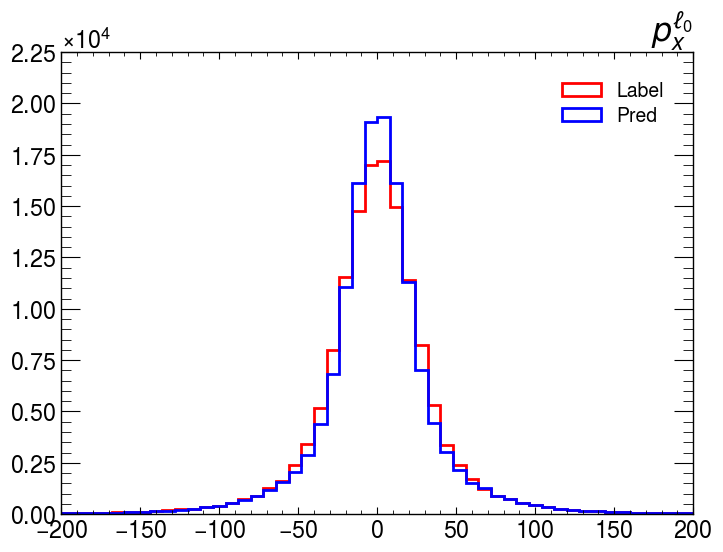

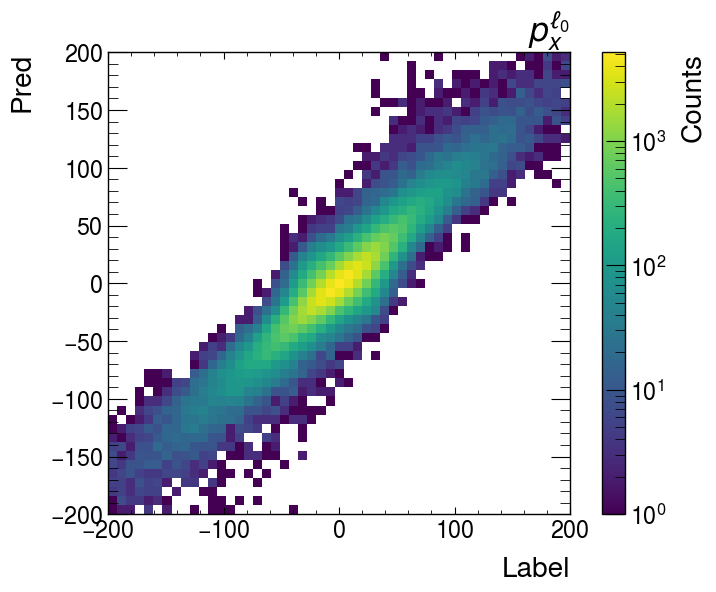

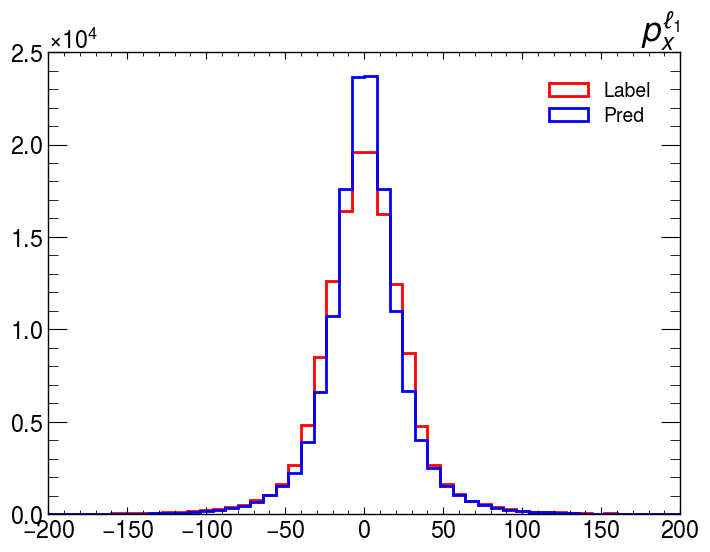

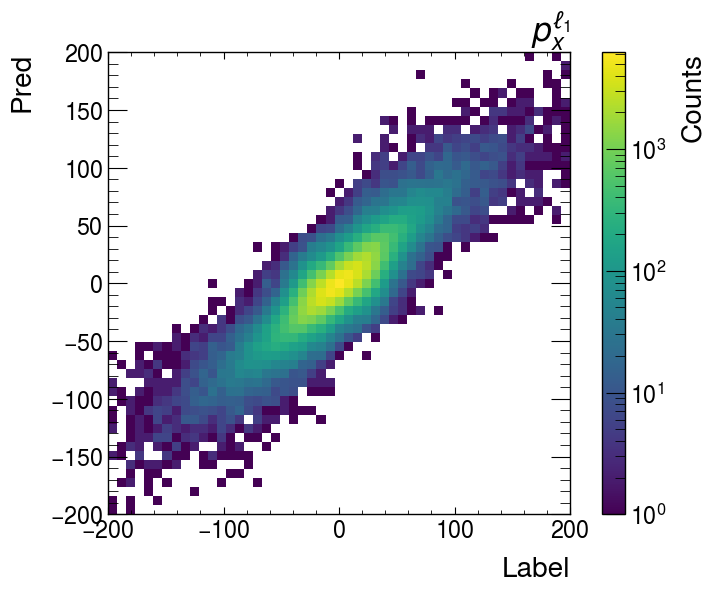

In [14]:
# px

# lead
plt.hist(label_lead_w_px, bins=np.linspace(-200, 200, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_lead_w_px, bins=np.linspace(-200, 200, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_0}_{x}$", loc='right')
plt.show()

plt.hist2d(
	label_lead_w_px,
	pred_lead_w_px,
	bins=(51, 51),
	range=([-200, 200], [-200, 200]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_0}_{x}$", loc='right')
plt.show()

# sublead px
plt.hist(label_sublead_w_px, bins=np.linspace(-200, 200, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_sublead_w_px, bins=np.linspace(-200, 200, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_1}_{x}$", loc='right')
plt.show()

plt.hist2d(
	label_sublead_w_px,
	pred_sublead_w_px,
	bins=(51, 51),
	range=([-200, 200], [-200, 200]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_1}_{x}$", loc='right')
plt.show()

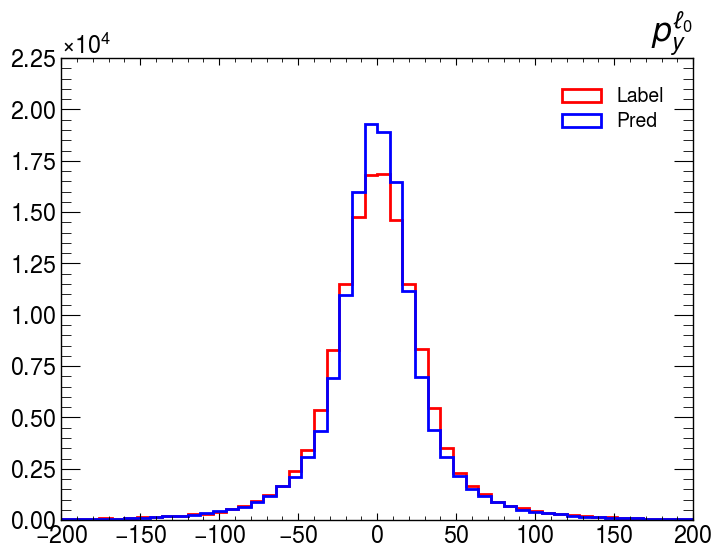

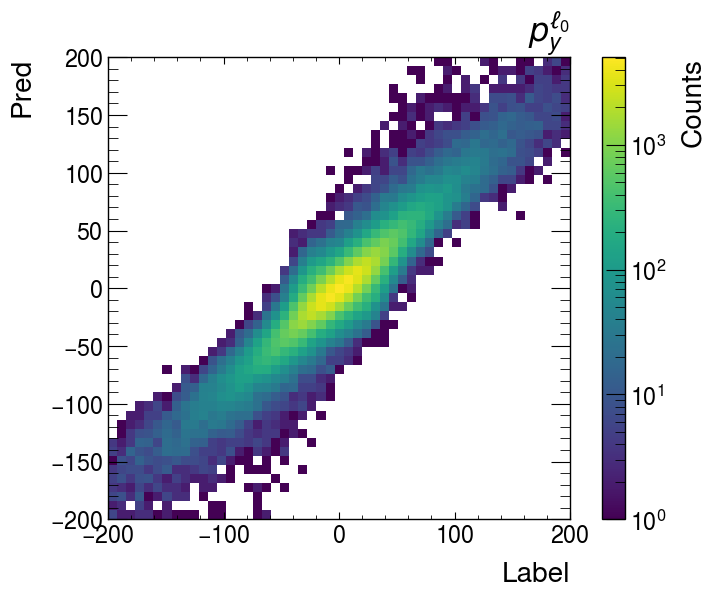

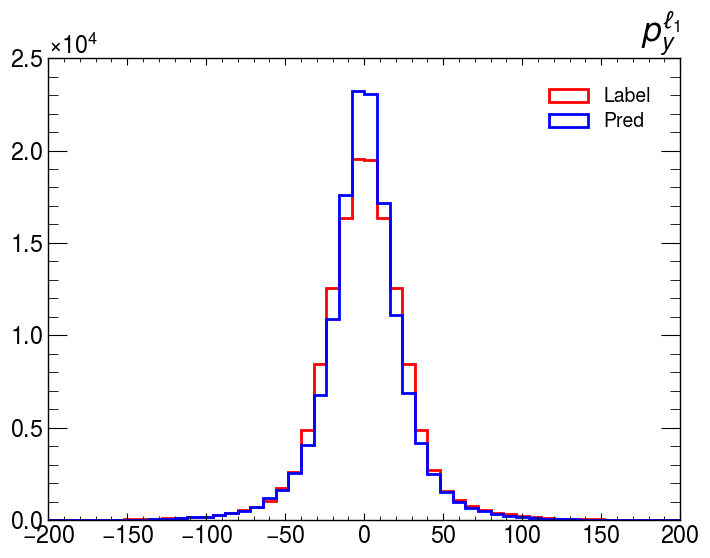

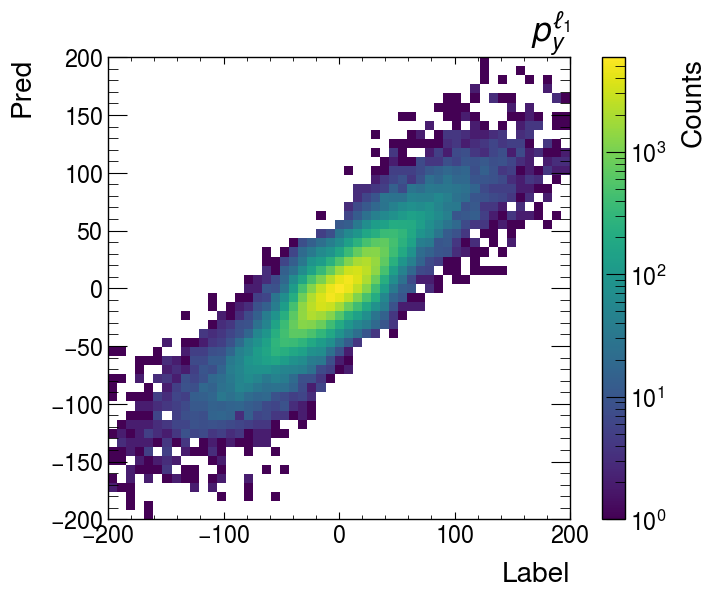

In [15]:
# py

# lead
plt.hist(label_lead_w_py, bins=np.linspace(-200, 200, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_lead_w_py, bins=np.linspace(-200, 200, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_0}_{y}$", loc='right')
plt.show()

plt.hist2d(
	label_lead_w_py,
	pred_lead_w_py,
	bins=(51, 51),
	range=([-200, 200], [-200, 200]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_0}_{y}$", loc='right')
plt.show()

# sublead py
plt.hist(label_sublead_w_py, bins=np.linspace(-200, 200, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_sublead_w_py, bins=np.linspace(-200, 200, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_1}_{y}$", loc='right')
plt.show()

plt.hist2d(
	label_sublead_w_py,
	pred_sublead_w_py,
	bins=(51, 51),
	range=([-200, 200], [-200, 200]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_1}_{y}$", loc='right')
plt.show()

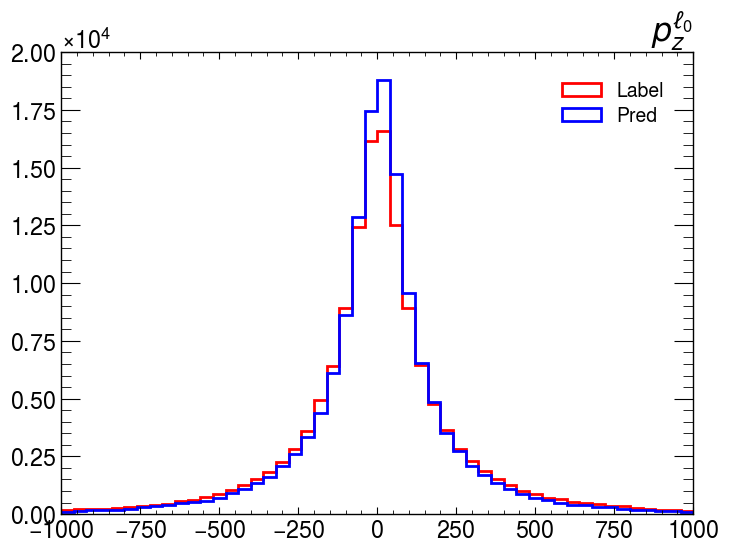

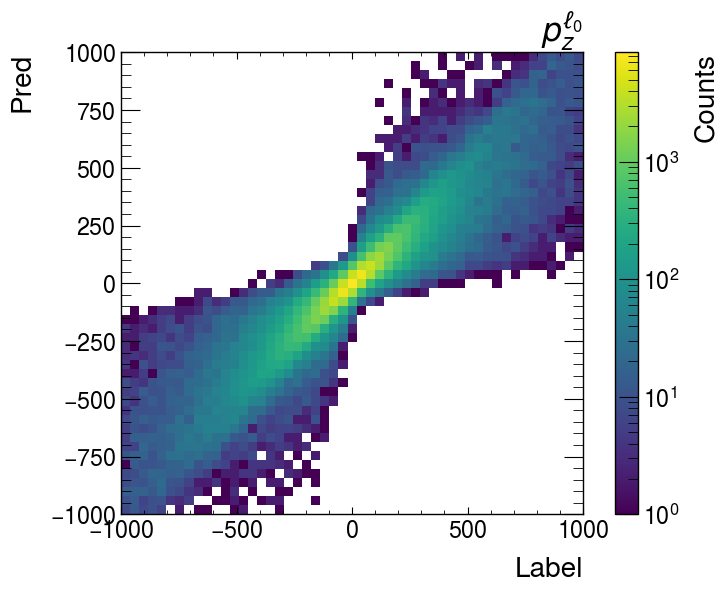

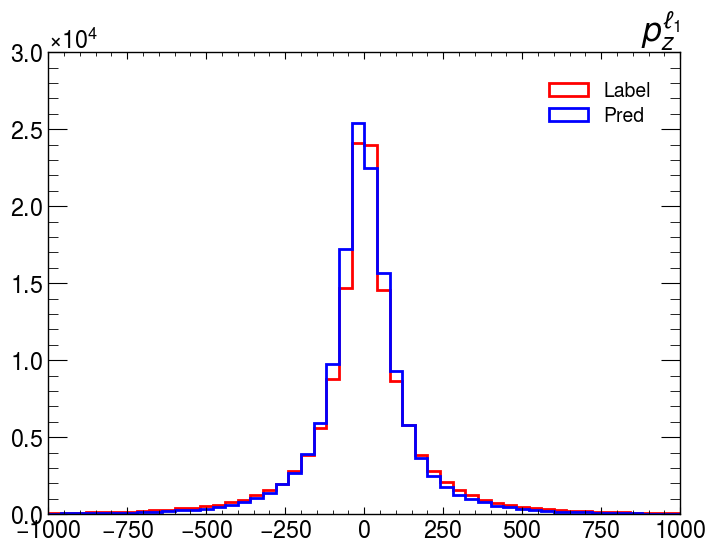

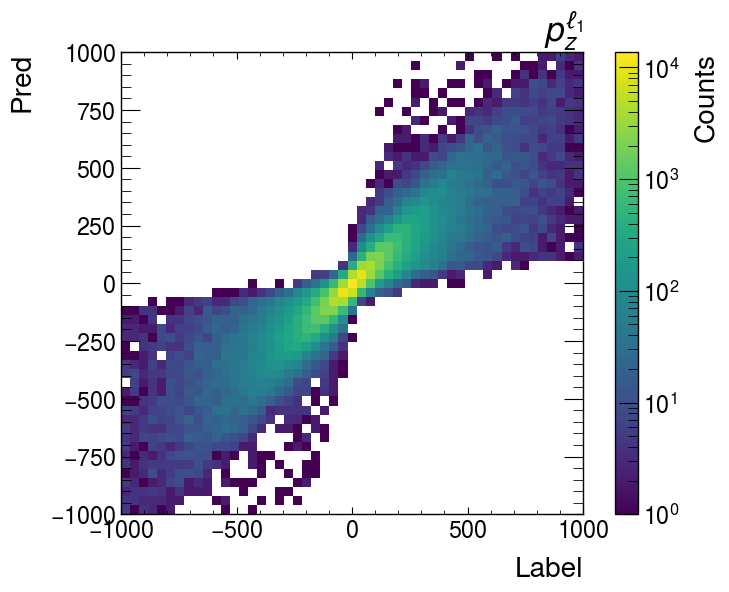

In [16]:
# pz

# lead
plt.hist(label_lead_w_pz, bins=np.linspace(-1000, 1000, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_lead_w_pz, bins=np.linspace(-1000, 1000, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_0}_{z}$", loc='right')
plt.show()

plt.hist2d(
	label_lead_w_pz,
	pred_lead_w_pz,
	bins=(51, 51),
	range=([-1000, 1000], [-1000, 1000]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_0}_{z}$", loc='right')
plt.show()

# sublead pz
plt.hist(label_sublead_w_pz, bins=np.linspace(-1000, 1000, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_sublead_w_pz, bins=np.linspace(-1000, 1000, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_1}_{z}$", loc='right')
plt.show()

plt.hist2d(
	label_sublead_w_pz,
	pred_sublead_w_pz,
	bins=(51, 51),
	range=([-1000, 1000], [-1000, 1000]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_1}_{z}$", loc='right')
plt.show()

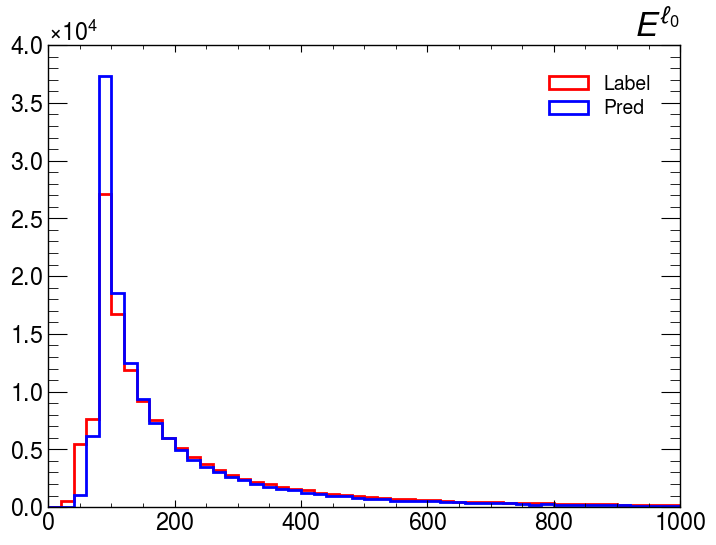

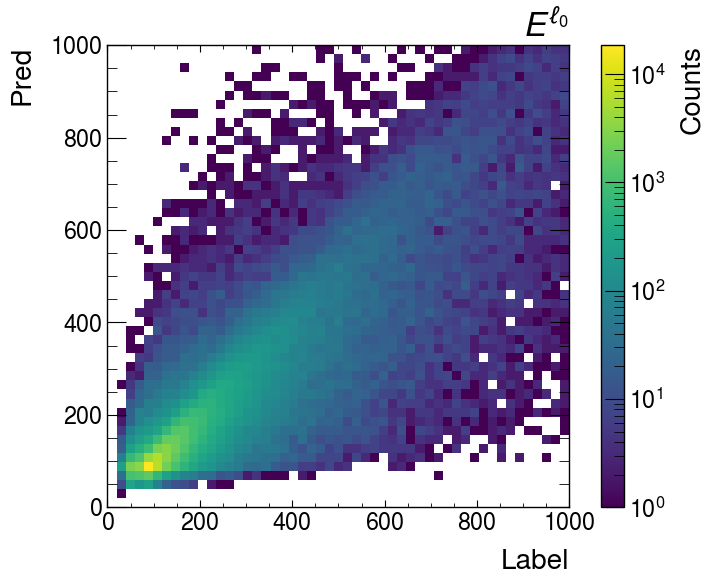

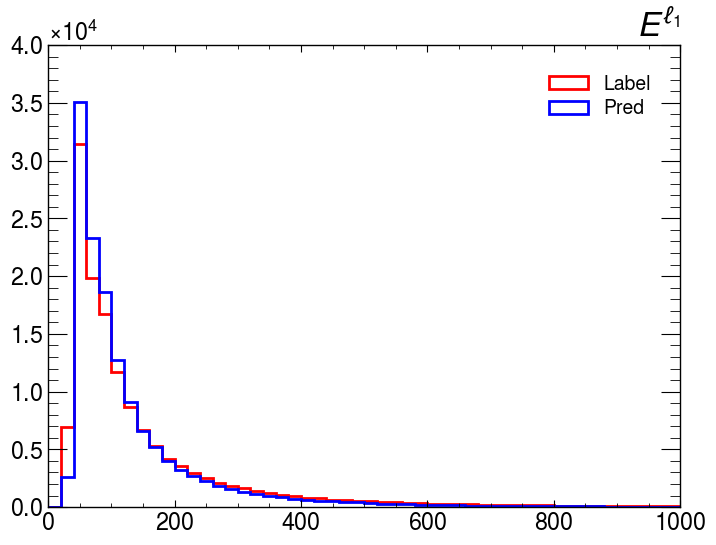

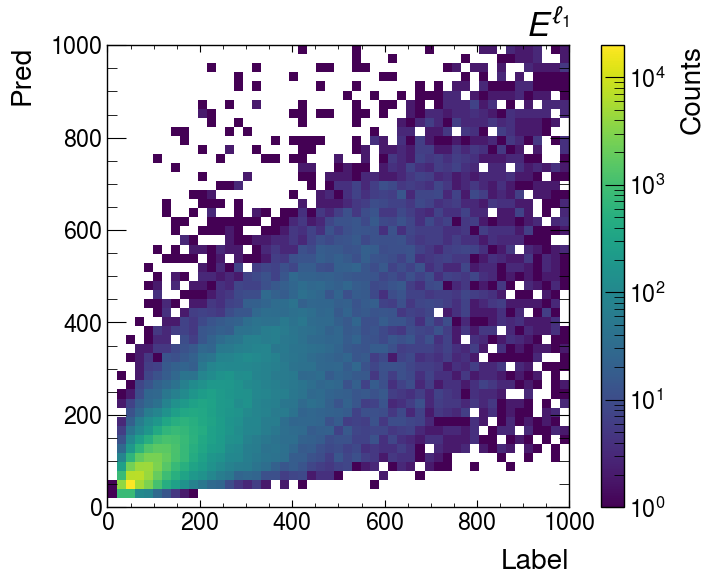

In [17]:
# energy

# lead
plt.hist(label_lead_w_energy, bins=np.linspace(0, 1000, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_lead_w_energy, bins=np.linspace(0, 1000, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$E^{\ell_0}$", loc='right')
plt.show()

plt.hist2d(
	label_lead_w_energy,
	pred_lead_w_energy,
	bins=(51, 51),
	range=([0, 1000], [0, 1000]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$E^{\ell_0}$", loc='right')
plt.show()

# sublead energy
plt.hist(label_sublead_w_energy, bins=np.linspace(0, 1000, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_sublead_w_energy, bins=np.linspace(0, 1000, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$E^{\ell_1}$", loc='right')
plt.show()

plt.hist2d(
	label_sublead_w_energy,
	pred_sublead_w_energy,
	bins=(51, 51),
	range=([0, 1000], [0, 1000]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$E^{\ell_1}$", loc='right')
plt.show()

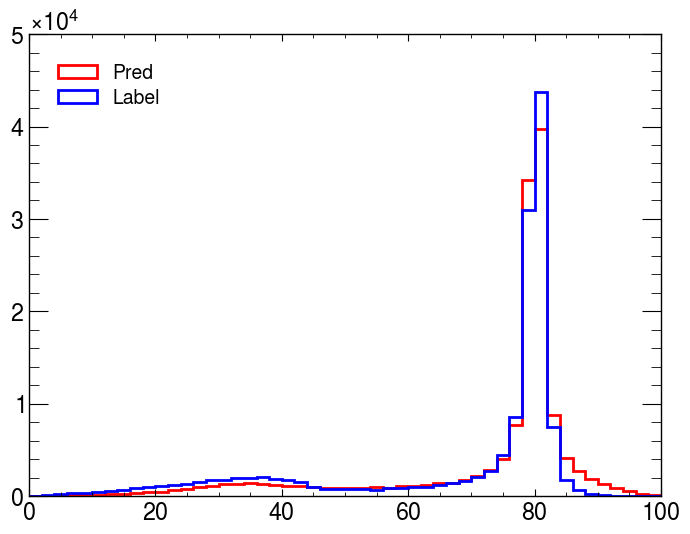

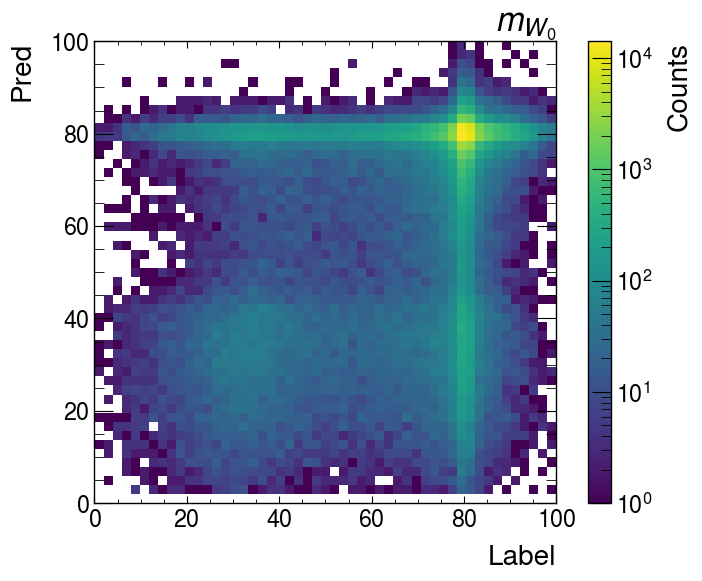

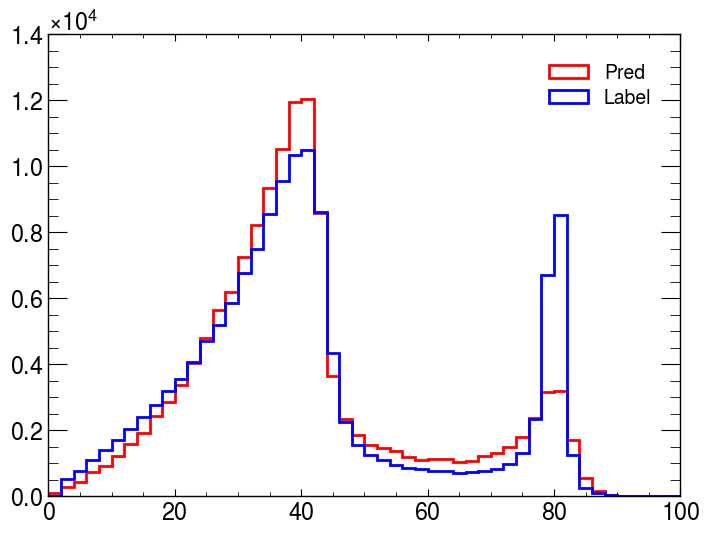

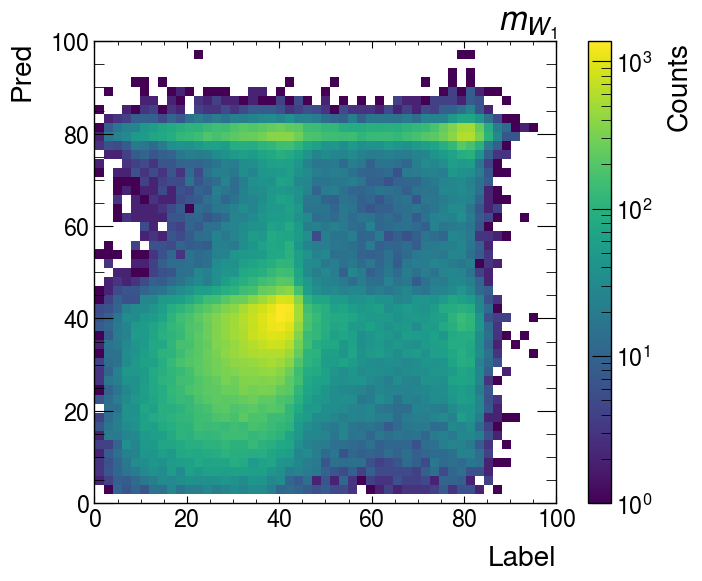

In [18]:
# W inv mass

w_lead_pred = np.sqrt(
	np.square(pred_lead_w_energy)
	- np.square(pred_lead_w_px)
	- np.square(pred_lead_w_py)
	- np.square(pred_lead_w_pz)
)
w_sublead_pred = np.sqrt(
	np.square(pred_sublead_w_energy)
	- np.square(pred_sublead_w_px)
	- np.square(pred_sublead_w_py)
	- np.square(pred_sublead_w_pz)
)
w_lead_label = np.sqrt(
	np.square(label_lead_w_energy)
	- np.square(label_lead_w_px)
	- np.square(label_lead_w_py)
	- np.square(label_lead_w_pz)
)
w_sublead_label = np.sqrt(
	np.square(label_sublead_w_energy)
	- np.square(label_sublead_w_px)
	- np.square(label_sublead_w_py)
	- np.square(label_sublead_w_pz)
)

plt.hist(w_lead_pred, bins=np.linspace(0, 100, 51), label=r"Pred", histtype="step", linewidth=2, color="red")
plt.hist(w_lead_label, bins=np.linspace(0, 100, 51), label=r"Label", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.xlim(0, 100)
plt.show()

plt.hist2d(
	w_lead_pred,
	w_lead_label,
	bins=(51, 51),
	range=([0, 100], [0, 100]),
	cmap="viridis",
	cmin=1,
	norm = LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel("Pred")
plt.xlabel("Label")
plt.title(r"$m_{W_0}$", loc='right')
plt.show()


plt.hist(w_sublead_pred, bins=np.linspace(0, 100, 51), label="Pred", histtype="step", linewidth=2, color="red")
plt.hist(w_sublead_label, bins=np.linspace(0, 100, 51), label="Label", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.xlim(0, 100)
plt.show()

plt.hist2d(
	w_sublead_pred,
	w_sublead_label,
	bins=(51, 51),
	range=([0, 100], [0, 100]),
	cmap="viridis",
	cmin=1,
	norm = LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel("Pred")
plt.xlabel("Label")
plt.title(r"$m_{W_1}$", loc='right')
plt.show()

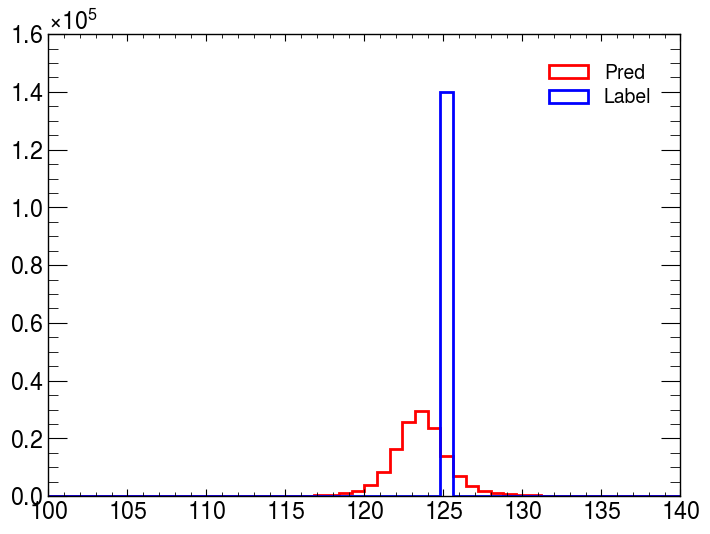

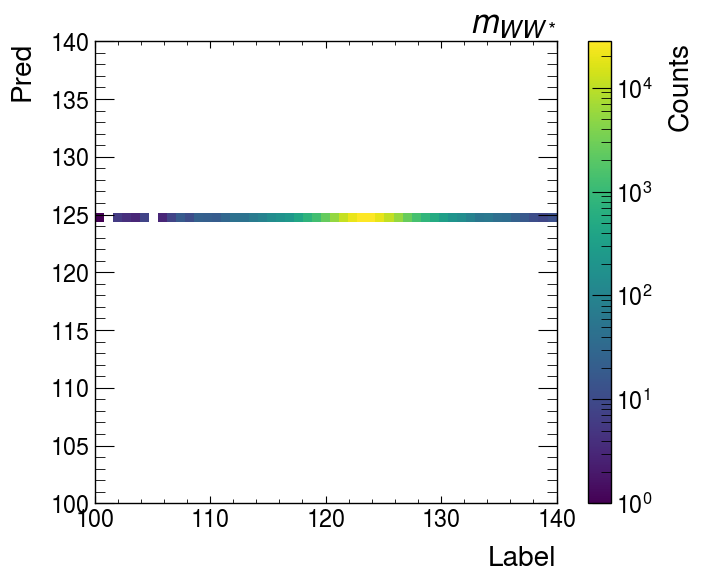

In [19]:
# WW* inv mass
ww_pred = np.sqrt(
	np.square(pred_lead_w_energy + pred_sublead_w_energy)
	- np.square(pred_lead_w_px + pred_sublead_w_px)
	- np.square(pred_lead_w_py + pred_sublead_w_py)
	- np.square(pred_lead_w_pz + pred_sublead_w_pz)
)
ww_label = np.sqrt(
	np.square(label_lead_w_energy + label_sublead_w_energy)
	- np.square(label_lead_w_px + label_sublead_w_px)
	- np.square(label_lead_w_py + label_sublead_w_py)
	- np.square(label_lead_w_pz + label_sublead_w_pz)
)
plt.hist(ww_pred, bins=np.linspace(100, 140, 51), label="Pred", histtype="step", linewidth=2, color="red")
plt.hist(ww_label, bins=np.linspace(100, 140, 51), label="Label", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.xlim(100, 140)
plt.show()

plt.hist2d(
	ww_pred,
	ww_label,
	bins=(51, 51),
	range=([100, 140], [100, 140]),
	cmap="viridis",
	cmin=1,
	norm = LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel("Pred")
plt.xlabel("Label")
plt.title(r"$m_{WW^\ast}$", loc='right')
plt.show()